In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wine-dataset-for-clustering/wine-clustering.csv


In [2]:
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage,dendrogram,cut_tree

In [3]:
wine = pd.read_csv('/kaggle/input/wine-dataset-for-clustering/wine-clustering.csv')
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


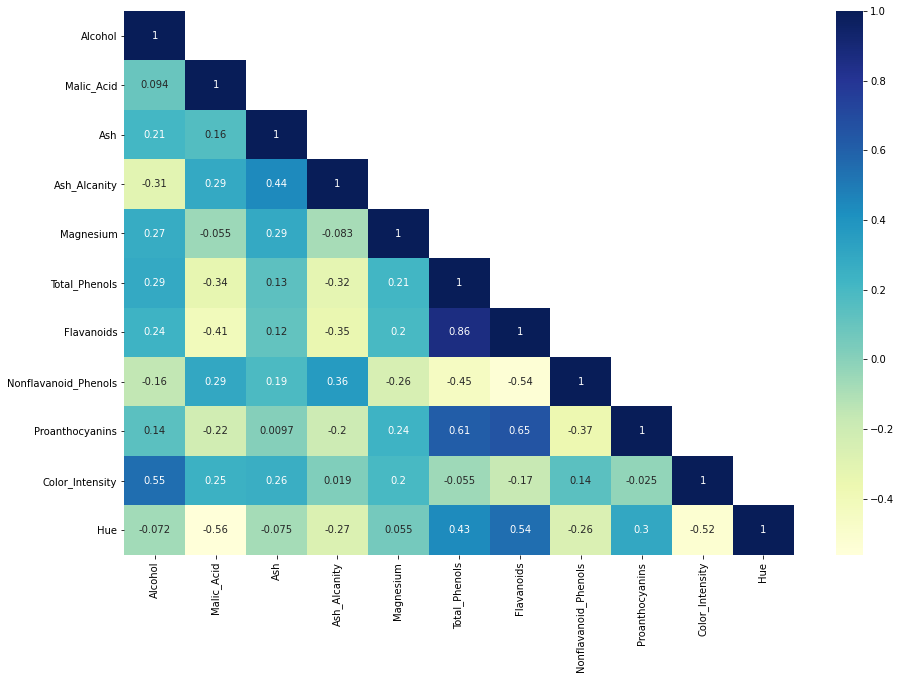

In [5]:
plt.figure(figsize=(15,10))
mask = np.triu(wine.iloc[:,:-2].corr(),1)
sns.heatmap(wine.iloc[:,:-2].corr(), annot=True, mask=mask, cmap="YlGnBu")
plt.show()

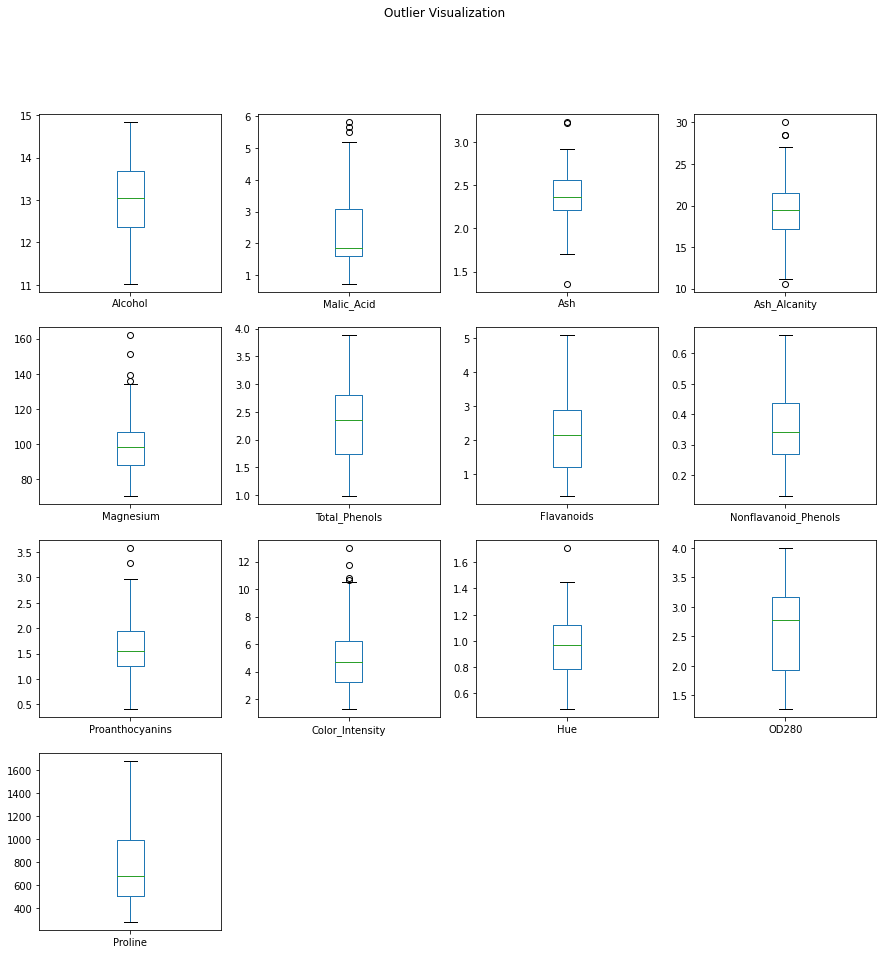

In [6]:
wine.plot(kind='box', subplots=True, layout=(4,4), figsize=(15,15), title='Outlier Visualization')
plt.show()

In [7]:
scaler = StandardScaler()
df = scaler.fit_transform(wine)
df = pd.DataFrame(df, columns=wine.columns)
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


In [8]:
def hopkins(X):
    
    from sklearn.neighbors import NearestNeighbors
    from random import sample
    from numpy.random import uniform
    import numpy as np
    from math import isnan
    
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [9]:
hopkins_score = np.array([hopkins(df) for i in range(10)]).mean()
print('Hopkins score =',hopkins_score)

Hopkins score = 0.718014373236913


## K-Means

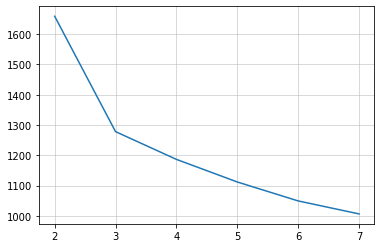

In [10]:
inertia = []
num_of_clusters = np.arange(2,8)
for i in num_of_clusters:
    km = KMeans(n_clusters=i, max_iter=100, random_state=100)
    km.fit(df)    
    inertia.append(km.inertia_)
    
plt.plot(num_of_clusters, inertia)
plt.grid(alpha=0.6)
plt.show()

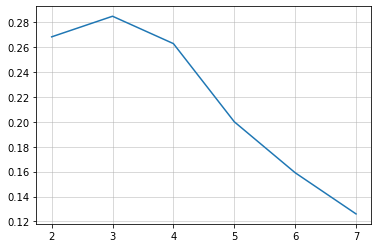

In [11]:
sil = []
num_of_clusters = np.arange(2,8)
for i in num_of_clusters:
    km = KMeans(n_clusters=i, max_iter=100, random_state=100)
    km.fit(df)    
    sil.append(silhouette_score(df, km.labels_))
    
plt.plot(num_of_clusters, sil)
plt.grid(alpha=0.6)
plt.show()

In [12]:
## 3 clusters seem to be fairly a good choice

km = KMeans(n_clusters=3, max_iter=100, random_state=100)
km.fit(df)

wine['km_cluster_id'] = km.labels_
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,km_cluster_id
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


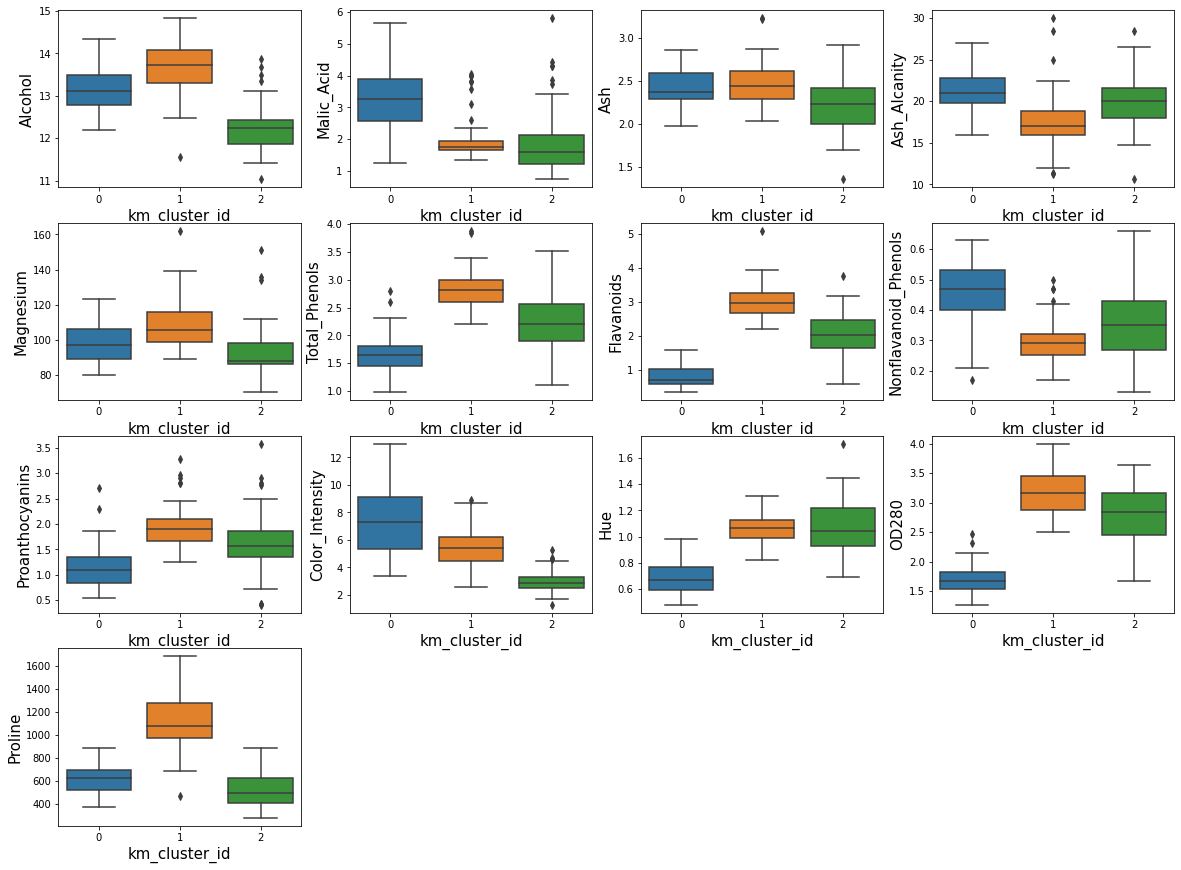

In [13]:
plt.figure(figsize=(20,15))
for i in enumerate(wine.columns[:-1]):
    plt.subplot(4,4,i[0]+1)
    sns.boxplot(x=wine.km_cluster_id, y=wine[i[1]])
    plt.xlabel('km_cluster_id',fontsize=15)
    plt.ylabel(i[1],fontsize=15)
plt.show()

## Agglomerative Clustering

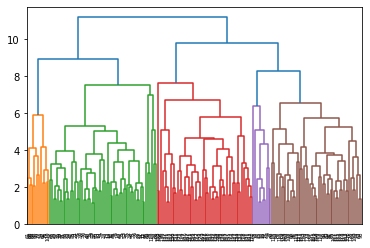

In [14]:
links = linkage(df, method='complete')
dendrogram(links)
plt.show()

In [15]:
ag = AgglomerativeClustering(n_clusters=5, linkage='complete')
ag.fit_predict(df)

wine['ag_cluster_id'] = ag.labels_
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,km_cluster_id,ag_cluster_id
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,4


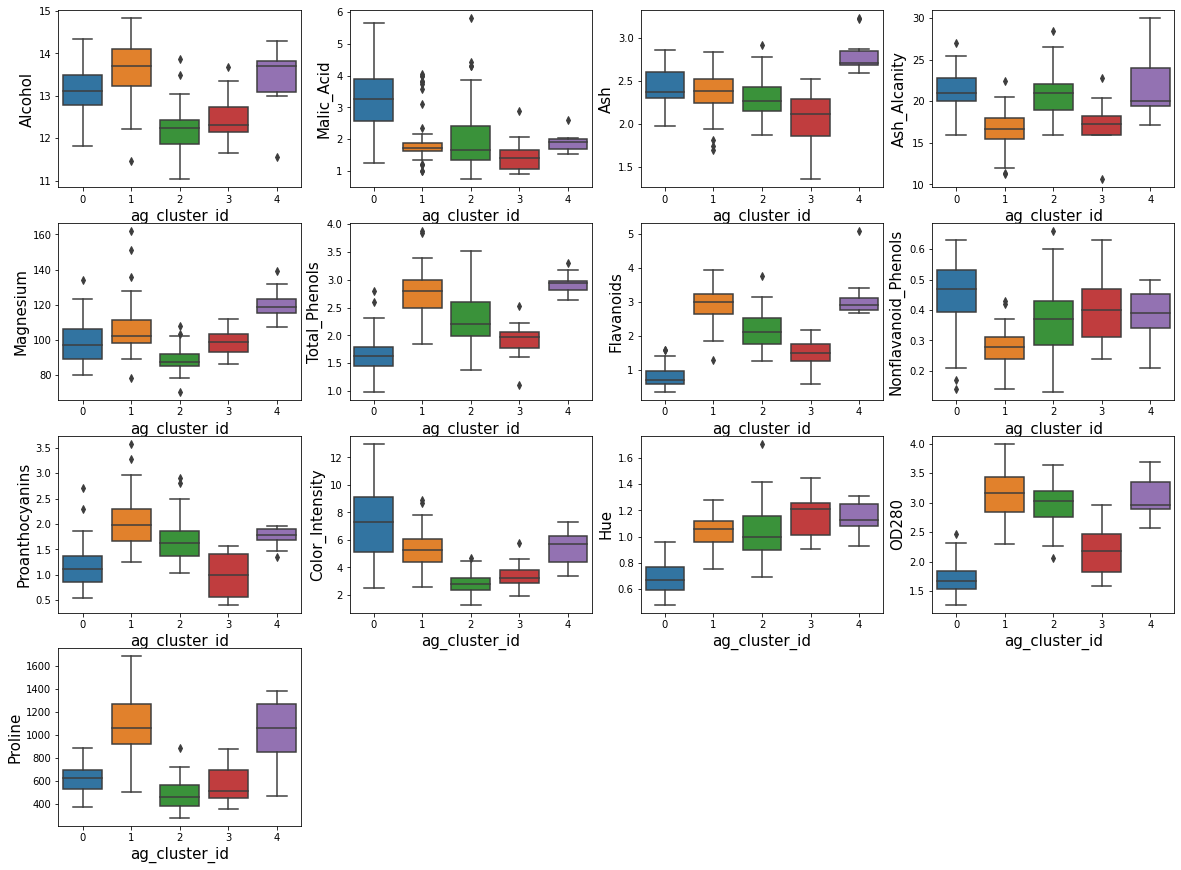

In [16]:
plt.figure(figsize=(20,15))
for i in enumerate(wine.columns[:-2]):
    plt.subplot(4,4,i[0]+1)
    sns.boxplot(x=wine.ag_cluster_id, y=wine[i[1]])
    plt.xlabel('ag_cluster_id',fontsize=15)
    plt.ylabel(i[1],fontsize=15)
plt.show()